In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import xgboost
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report 
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB

# Importing data

In [39]:
df = pd.read_csv("/kaggle/input/finaldataset/final-dataset.csv")
df.shape

(2019, 7)

In [40]:
df.sample(2)

,id,keyword,text,target,RoBERTa,Accuracy,Unnamed: 6
1391,1392,panic,I would like to not scream in the void but I h...,0,0,1,NaN
366,367,burning,@elonmusk I made this video after living throu...,0,1,0,NaN


# Checking label distribution

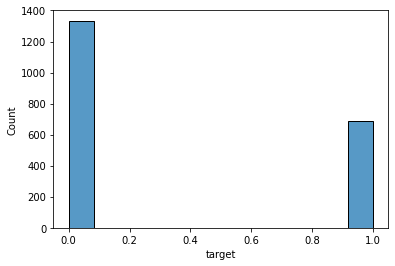

In [41]:
sns.histplot(df['target']);

# Deleting unnecessary features

In [43]:
#df = df.drop(labels=['id','location'],axis=1)
df = df.drop(labels=['id','RoBERTa', 'Accuracy'],axis=1)
df = df.iloc[:, :-1]
df

,keyword,text,target
0,ablaze,"Yesterday, at Igando, two men allegedly robbed...",1
1,ablaze,- NDLEA sets ablaze the N194 Billion worth of ...,1
2,ablaze,Putin's cancelled speech appears to have set M...,1
3,ablaze,"Seeing all over the country, people wearing ma...",0
4,ablaze,Death of a girl set ablaze in Dumka | Jharkhan...,1
...,...,...,...
2014,wrecked,This the second time I wrecked my car this yea...,0
2015,wrecked,@MikeBaggz Biden wrecked tens of thousands of ...,0
2016,wrecked,I do not like driving! My nerves be wrecked dr...,0
2017,wrecked,"i’m so sick and tired of work, this week reall...",0


# Checking for null values (NaN)

In [45]:
df.shape
df.isna().sum()

keyword    0
text       0
target     0
dtype: int64

# Checking for duplicated values 

In [46]:
df['text'].duplicated().sum()
df.shape

(2019, 3)

# Deleting duplicates

In [47]:
df = df.drop_duplicates(subset=['text'],keep=False)

# Creating a target variable for binary classification

In [48]:
df.shape

(1993, 3)

In [49]:
df = df.dropna()
y_df = df['target']
df = df.drop(labels=['target'],axis=1)

# Reseting index

In [50]:
df = df.reset_index()
df = df.drop(labels=['index'],axis=1)

# Replacing odd writing in Dataset
This step will facilitate tokenization!

In [52]:
df['keyword'] = df['keyword'].str.replace('%20',' ')
df['keyword'].sample(50)

1194                  lava
710                drought
1527                 ruin 
1170            inundation
656               detonate
299                bombing
1979              wreckage
256                   bomb
1560               screams
290                 bombed
1312       nuclear reactor
1786               trapped
953             fire truck
1266              meltdown
185                blazing
1506               rioting
16                accident
31               ambulance
156               attacked
1928              wildfire
729                drowned
1666    structural failure
986              flattened
375             casualties
173                 battle
835               evacuate
811     emergency services
259                   bomb
1841               twister
1135               injured
1108               hostage
1617                 smoke
461                  crash
1019           forest fire
1242              massacre
587             demolition
166                 battle
1

# Encoding the 'keyword' Column

In [53]:
keyword_dummies = pd.get_dummies(df['keyword'])

# Simple algorithm for text cleansing (Extracting the Vocabulary set!)

This simple algorithm checks for weird or wrong characters in strings,
and if a string is found, it will not enter in our vocabulary!

E.g :. '3672hjdkhj' is a string that should not enter our model!

In [54]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(stop_words='english')

text_vectorizer = vect.fit_transform(df['text'])

arr = vect.get_feature_names_out()
forbidden = ['0','1','2','3','4','5','6','7','8','9','_','@','ü','ò','û','$','%','*','#','/','â','!','[',']','.',';','ç','>','å']
stop = []
i = -1
for item in arr:
  i = i+1
  for letter in item:
    if letter in forbidden:
      stop.append(item)
print(len(stop))

3590


# Creating our vocabulary with set operations

A set is a very simple data structure in which scikit-learn requires us to use, for vocabulary.

we are removing from arr (which contains all the words), those that are unwanted (contained in the 'stop' set).


In [55]:
stop = set(stop)
arr = set(arr)
vocab = arr - stop
len(vocab)

10054

# Tokenizing our data using our vocabulary

In [56]:
from sklearn.feature_extraction.text import CountVectorizer
vect2 = CountVectorizer(stop_words='english',vocabulary=vocab)
text_vectorizer2 = vect2.fit_transform(df['text'])
arr2 = vect2.get_feature_names()

# Data Frame created with 'text' column tokenization

In [57]:
text_df = pd.DataFrame(text_vectorizer2.toarray())
text_df

,0,1,2,3,4,5,6,7,8,9,...,10044,10045,10046,10047,10048,10049,10050,10051,10052,10053
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1988,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1989,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1990,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1991,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Creating a fully pre-processed df

(hence the name 'proc_df', processed_df)

In [58]:
proc_df = pd.concat([keyword_dummies,text_df],axis=1)

In [59]:
proc_df

,ablaze,accident,ambulance,annihilated,annihilation,apocalypse,army,arson,arsonist,attack,...,10044,10045,10046,10047,10048,10049,10050,10051,10052,10053
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1988,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1989,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1990,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1991,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Splitting the data: train and test

In [60]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(proc_df,y_df)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((1494, 10248), (499, 10248), (1494,), (499,))

# Training the model

In [60]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost
xgb = xgboost.XGBClassifier()

In [61]:
params = {
 "learning_rate": [0.05,0.10,0.15,0.20,0.25,0.30],
 "max_depth": [ 3, 4, 6, 8, 10, 15],
 "gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree": [ 0.3, 0.4, 0.5 , 0.7 ]
}

In [62]:
xgb_rs_model = RandomizedSearchCV(xgb,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=4,verbose=3)

In [63]:
xgb_rs_model.fit(x_train, y_train)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


RandomizedSearchCV(cv=4,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=

In [64]:
xgb_rs_model.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.25, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [96]:
xgb_model= xgboost.XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.25, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
              monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1)

In [98]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(xgb_model,x_train,y_train,cv=10)
score.mean()

0.7981153015060614

In [102]:
xgb_model.fit(proc_df,y_df)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.25, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [144]:
xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.25, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [145]:
y_pred = xgb_model.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.75      0.91      0.82      1031
           1       0.84      0.62      0.72       814

    accuracy                           0.78      1845
   macro avg       0.80      0.76      0.77      1845
weighted avg       0.79      0.78      0.78      1845



In [103]:
from sklearn.metrics import classification_report 
y_pred = xgb_model.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.79      0.95      0.86      1031
           1       0.91      0.68      0.78       814

    accuracy                           0.83      1845
   macro avg       0.85      0.82      0.82      1845
weighted avg       0.84      0.83      0.83      1845



In [125]:
cat_params = {
    'depth':[3,1,2,4,6,8,10],
    'iterations':[250,100,500,1000],
    'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
    'l2_leaf_reg':[3,1,5,10,100]
}

In [128]:
from catboost import CatBoostClassifier
cat = CatBoostClassifier(silent=True)
cat_rs_model = RandomizedSearchCV(cat,param_distributions=cat_params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=4)

In [129]:
cat_rs_model.fit(x_train, y_train)

RandomizedSearchCV(cv=4,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7fb2cd850210>,
                   n_iter=5, n_jobs=-1,
                   param_distributions={'depth': [3, 1, 2, 4, 6, 8, 10],
                                        'iterations': [250, 100, 500, 1000],
                                        'l2_leaf_reg': [3, 1, 5, 10, 100],
                                        'learning_rate': [0.03, 0.001, 0.01,
                                                          0.1, 0.2, 0.3]},
                   scoring='roc_auc')

In [133]:
cat_rs_model.best_params_

{'learning_rate': 0.3, 'l2_leaf_reg': 1, 'iterations': 1000, 'depth': 10}

In [138]:
cat_model = CatBoostClassifier(verbose=False, learning_rate= 0.3, l2_leaf_reg= 1, iterations= 1000, depth= 10)

In [139]:
cat_model.fit(proc_df,y_df)

In [140]:
y_pred = cat_model.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1031
           1       1.00      0.99      0.99       814

    accuracy                           0.99      1845
   macro avg       0.99      0.99      0.99      1845
weighted avg       0.99      0.99      0.99      1845



In [141]:
cat_score = cross_val_score(cat_model,x_train,y_train,cv=5)
cat_score.mean()

0.7925182669548214

In [142]:
cat_model.fit(x_train, y_train)

In [143]:
y_pred = cat_model.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.76      0.87      0.81      1031
           1       0.80      0.65      0.72       814

    accuracy                           0.77      1845
   macro avg       0.78      0.76      0.76      1845
weighted avg       0.78      0.77      0.77      1845



In [165]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB(var_smoothing=0.01873817422860384)
model.fit(proc_df,y_df)

GaussianNB(var_smoothing=0.01873817422860384)

# Classification report!

In [166]:
from sklearn.metrics import classification_report 
y_pred = model.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.93      0.87      1031
           1       0.89      0.73      0.80       814

    accuracy                           0.84      1845
   macro avg       0.85      0.83      0.83      1845
weighted avg       0.85      0.84      0.84      1845



In [61]:
xgb_model= xgboost.XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.25, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
              monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1)
cat_model = CatBoostClassifier(verbose=False, learning_rate= 0.3, l2_leaf_reg= 1, iterations= 1000, depth= 10)
model = GaussianNB(var_smoothing=0.01873817422860384)

In [62]:
vc_model = VotingClassifier(estimators=[('xgb', xgb_model), ('cat', cat_model), ('gau', model)], voting='soft')

In [63]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(vc_model,x_train,y_train,cv=4)
score.mean()

0.7423119381800978

In [66]:
vc_model.fit(x_train,y_train)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            callbacks=None, colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=0.3,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, gamma=0.0,
                                            gpu_id=-1, grow_policy='depthwise',
                                            importance_type=None,
                                            interaction_constraints='',
                                            learning_rate=0.25, max_bin=256,
                                            m...ehot=4,
                                            max_delta_step=0, max_depth=10,
                                

In [67]:
from sklearn.metrics import classification_report 
y_pred = vc_model.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.78      0.82       348
           1       0.58      0.72      0.64       151

    accuracy                           0.76       499
   macro avg       0.72      0.75      0.73       499
weighted avg       0.78      0.76      0.76       499



# Importing test data

In [202]:
#test_df = pd.read_csv(r'../input/nlp-getting-started/test.csv')
test_df = pd.read_csv("/kaggle/input/uploadtest/tweets.csv")

In [203]:
index = test_df['id']

test_df = test_df[['keyword','text']]

test_df

,keyword,text
0,ablaze,'@elonmusk This is like an arsonist asking wha...
1,ablaze,'I'm watching Patty Arquette on tv thinking ab...
2,ablaze,'NEW: Remember the viral “insulin is free” par...
3,ablaze,'As an adult you should work on your conflict ...
4,ablaze,'❤️‍🔥 Setting the @WWE Universe’s heart ablaze...
...,...,...
948,crushed,'Thread of some Actors that crushed a role so ...
949,crushed,'Oh my god I just learned I am unable to cross...
950,crushed,'The Professor crushed his soul https://t.co/...
951,crushed,'This level of betrayal will never be forgiven...


# Pre-processing test data

In [204]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')
test_df['keyword'] = imputer.fit_transform(test_df['keyword'].values.reshape(-1, 1))
test_df['text'] = imputer.fit_transform(test_df['text'].values.reshape(-1, 1))

In [205]:
test_df.isna().sum()

keyword    0
text       0
dtype: int64

In [206]:
test_df['keyword'] = test_df['keyword'].str.replace('%20',' ')
test_df['keyword'].sample(50)

824      collision
308         battle
858          crash
286         battle
803      collision
666       casualty
296         battle
249       attacked
251       attacked
784        collide
396         blight
949        crushed
515         bombed
441          blood
14          ablaze
773        collide
805      collision
182       arsonist
416       blizzard
17        accident
544        bombing
892        crashed
318        blazing
647     casualties
346        blazing
717       collapse
137           army
420          blood
293         battle
120     apocalypse
8           ablaze
749      collapsed
198       arsonist
258       attacked
438          blood
386         blight
187       arsonist
340        blazing
43        accident
477         bloody
902          crush
74     annihilated
786        collide
243       attacked
930        crushed
88     annihilated
641     casualties
0           ablaze
408       blizzard
131           army
Name: keyword, dtype: object

In [207]:
keyword_dummies_TEST = pd.get_dummies(test_df['keyword'])

In [208]:
keyword_dummies_TEST

,ablaze,accident,ambulance,annihilated,annihilation,apocalypse,army,arson,arsonist,attack,...,catastrophic,collapse,collapsed,collide,collided,collision,crash,crashed,crush,crushed
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
948,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
949,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
950,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
951,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


# Tokenizing test data, extracting its own vocabulary

PS... We are extracting the test data vocabulary, but we will not use it! It is just for demonstration purposes!

In [209]:
from sklearn.feature_extraction.text import CountVectorizer
test_vect = CountVectorizer(stop_words='english')

text_vectorizer = test_vect.fit_transform(test_df['text'])

arrt = test_vect.get_feature_names_out()
forbidden = ['0','1','2','3','4','5','6','7','8','9','_','@','ü','ò','û','$','%','*','#','/','â','!','[',']','.',';','ç','>','å']
stop = []
i = -1
for item in arrt:
  i = i+1
  for letter in item:
    if letter in forbidden:
      stop.append(item)
stopt = set(stop)
arrt= set(arrt)
vocabt = arrt - stopt
len(vocabt)

6737

In [210]:
len(vocabt),len(vocab)

(6737, 15764)

# Tokenizing test data

In [211]:
from sklearn.feature_extraction.text import CountVectorizer
test_vect2 = CountVectorizer(stop_words='english',vocabulary=vocab)
test_text_vectorizer2 = test_vect2.fit_transform(test_df['text'])

In [212]:
text_df_TEST = pd.DataFrame(test_text_vectorizer2.toarray())
text_df_TEST

,0,1,2,3,4,5,6,7,8,9,...,15754,15755,15756,15757,15758,15759,15760,15761,15762,15763
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
948,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
949,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
950,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
951,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [213]:
proc_df_TEST = pd.concat([keyword_dummies_TEST,text_df_TEST],axis=1)

# Fully pre-processed test DataFrame

In [200]:
proc_df_TEST

,ablaze,accident,airplane accident,ambulance,annihilated,annihilation,apocalypse,army,arson,arsonist,...,15754,15755,15756,15757,15758,15759,15760,15761,15762,15763
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1027,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1028,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1029,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1030,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [68]:
xgb_model= xgboost.XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.25, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
              monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1)
cat_model = CatBoostClassifier(verbose=False, learning_rate= 0.3, l2_leaf_reg= 1, iterations= 1000, depth= 10)
model = GaussianNB(var_smoothing=0.01873817422860384)

In [19]:
xgb_model.fit(proc_df, y_df)
cat_model.fit(proc_df, y_df)

KeyboardInterrupt: 

In [161]:
y_pred_submiss_xgb = xgb_model.predict(proc_df_TEST)
y_pred_submiss_cat = cat_model.predict(proc_df_TEST)

In [163]:
final_df = pd.DataFrame()

final_df['id'] = index
final_df['target'] = y_pred_submiss_xgb
final_df.to_csv('submission_xgb.csv',index = False)
###score = 0.7971

In [164]:
final_df = pd.DataFrame()

final_df['id'] = index
final_df['target'] = y_pred_submiss_cat
final_df.to_csv('submission_cat.csv',index = False)
#score = 0.79068

In [69]:
model.fit(proc_df,y_df)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


GaussianNB(var_smoothing=0.01873817422860384)

In [214]:
y_pred_submiss = model.predict(proc_df_TEST)
proc_df_TEST.shape

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


ValueError: X has 15804 features, but GaussianNB is expecting 15985 features as input.

# Creating submission DataFrame

In [22]:
final_df = pd.DataFrame()

final_df['id'] = index
final_df['target'] = y_pred_submiss

In [23]:
final_df
final_df['target'].value_counts()

0    2147
1    1116
Name: target, dtype: int64

# Submitting!

In [24]:
final_df.to_csv('submission_naive.csv',index = False)
#score = 0.79068

In [172]:
model

GaussianNB(var_smoothing=0.01873817422860384)

In [24]:
from sklearn.ensemble import VotingClassifier

In [78]:
vc_model = VotingClassifier(estimators=[('xgb', xgb_model), ('cat', cat_model), ('gau', model)], voting='soft')

In [79]:
vc_model.fit(proc_df,y_df)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            callbacks=None, colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=0.3,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, gamma=0.0,
                                            gpu_id=-1, grow_policy='depthwise',
                                            importance_type=None,
                                            interaction_constraints='',
                                            learning_rate=0.25, max_bin=256,
                                            m...ehot=4,
                                            max_delta_step=0, max_depth=10,
                                

In [80]:
y_pred_submiss_voting = vc_model.predict(proc_df_TEST)

ValueError: Feature shape mismatch, expected: 15985, got 15810

In [178]:
final_df = pd.DataFrame()

final_df['id'] = index
final_df['target'] = y_pred_submiss_voting

In [179]:
final_df.to_csv('submission_voting.csv',index = False)
#score = 0.79834

In [180]:
vc_model.fit(x_train, y_train)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            callbacks=None, colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=0.3,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, gamma=0.0,
                                            gpu_id=-1, grow_policy='depthwise',
                                            importance_type=None,
                                            interaction_constraints='',
                                            learning_rate=0.25, max_bin=256,
                                            m...ehot=4,
                                            max_delta_step=0, max_depth=10,
                                

In [181]:
y_pred = vc_model.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.76      0.92      0.83      1031
           1       0.86      0.64      0.74       814

    accuracy                           0.80      1845
   macro avg       0.81      0.78      0.78      1845
weighted avg       0.81      0.80      0.79      1845

